In [ ]:
# Connecting drive with Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Pre-trained Model (VGG16)
!pip install tensorflow
!pip install keras

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16  # Import VGG16 from keras.applications
from tensorflow.keras.layers import Flatten, Dense, Dropout  # Import other necessary layers
from tensorflow.keras.models import Model  # Import Model
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
import matplotlib.pyplot as plt # Import matplotlib for plotting
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img # Import load_img
from tensorflow.keras.preprocessing.image import img_to_array # Import img_to_array
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

In [ ]:
# Define dataset paths
train_dir = "/content/drive/MyDrive/Breast Cancer Patients MRI/train"
val_dir = "/content/drive/MyDrive/Breast Cancer Patients MRI/validation"

## Custom CNN

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# ----- CONFIG -----
data_dir = "/content/drive/MyDrive/Breast Cancer Patients MRI/train"  # Update as needed
batch_size = 16
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- TRANSFORMS -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ----- DATASET -----
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ----- MODEL -----
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.net(x)

# ----- TRAINING -----
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    correct = total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}")

# ----- VALIDATION -----
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.numpy())

val_acc = accuracy_score(val_labels, val_preds)
cm = confusion_matrix(val_labels, val_preds)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")



Epoch 1/5 - Loss: 0.2677, Train Accuracy: 0.6973
Epoch 2/5 - Loss: 0.0328, Train Accuracy: 0.9437
Epoch 3/5 - Loss: 0.0550, Train Accuracy: 0.9821
Epoch 4/5 - Loss: 0.0015, Train Accuracy: 0.9875
Epoch 5/5 - Loss: 0.0490, Train Accuracy: 0.9893
Validation Accuracy: 0.9821
Train Accuracy: 0.9893


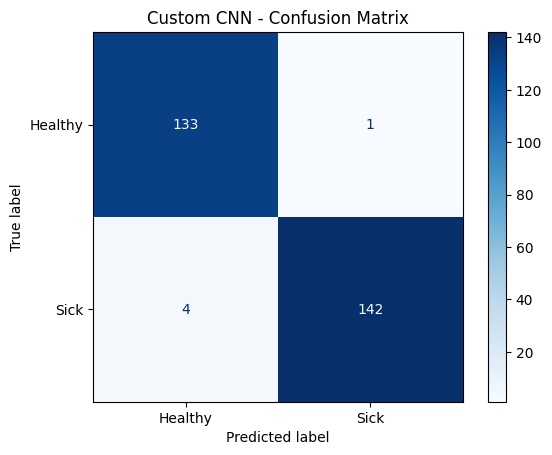

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Custom CNN - Confusion Matrix")
plt.show()


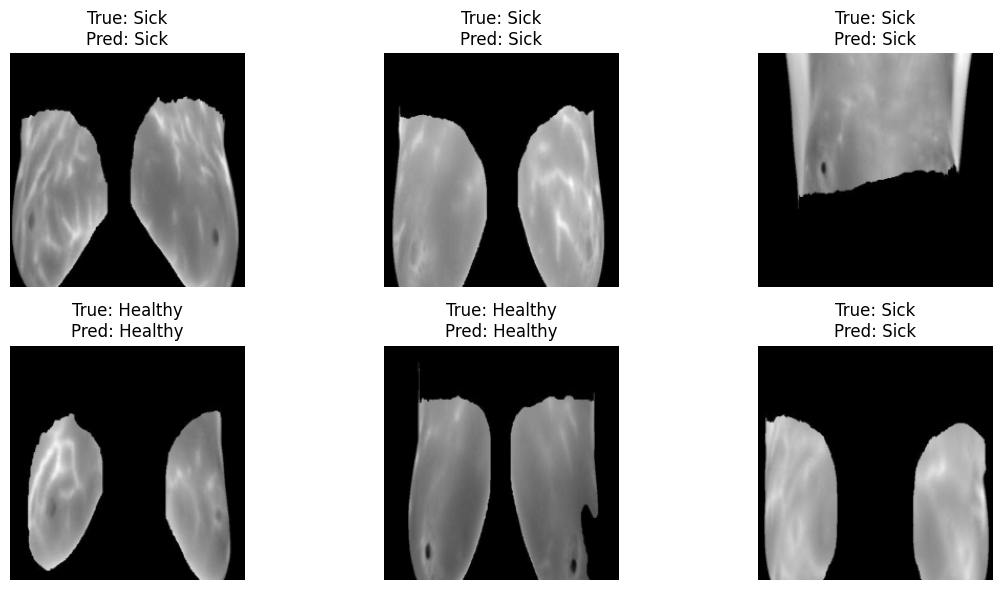

In [ ]:
import matplotlib.pyplot as plt
import torch

def show_grid_predictions(model, data_loader, class_names, device):
    model.eval()
    images, labels = next(iter(data_loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(6):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Unnormalize
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage:
show_grid_predictions(model, val_loader, class_names, device)


## ResNet18

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# ----- CONFIG -----
data_dir = "/content/drive/MyDrive/Breast Cancer Patients MRI/train"  # Change if needed
batch_size = 16
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- TRANSFORM -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # ResNet needs 3 channels
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ----- DATASET -----
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ----- MODEL (ResNet18) -----
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes
model = model.to(device)

# ----- TRAINING -----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    correct = total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}")

# ----- VALIDATION -----
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.numpy())

val_acc = accuracy_score(val_labels, val_preds)
cm = confusion_matrix(val_labels, val_preds)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.1MB/s]


Epoch 1/5 - Loss: 0.4084, Train Accuracy: 0.8161
Epoch 2/5 - Loss: 0.1306, Train Accuracy: 0.9071
Epoch 3/5 - Loss: 0.1373, Train Accuracy: 0.9437
Epoch 4/5 - Loss: 0.1084, Train Accuracy: 0.9580
Epoch 5/5 - Loss: 0.0978, Train Accuracy: 0.9670
Validation Accuracy: 0.9750
Train Accuracy: 0.9670


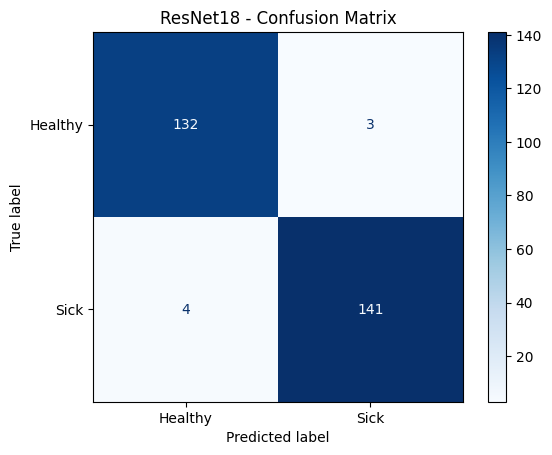

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("ResNet18 - Confusion Matrix")
plt.show()

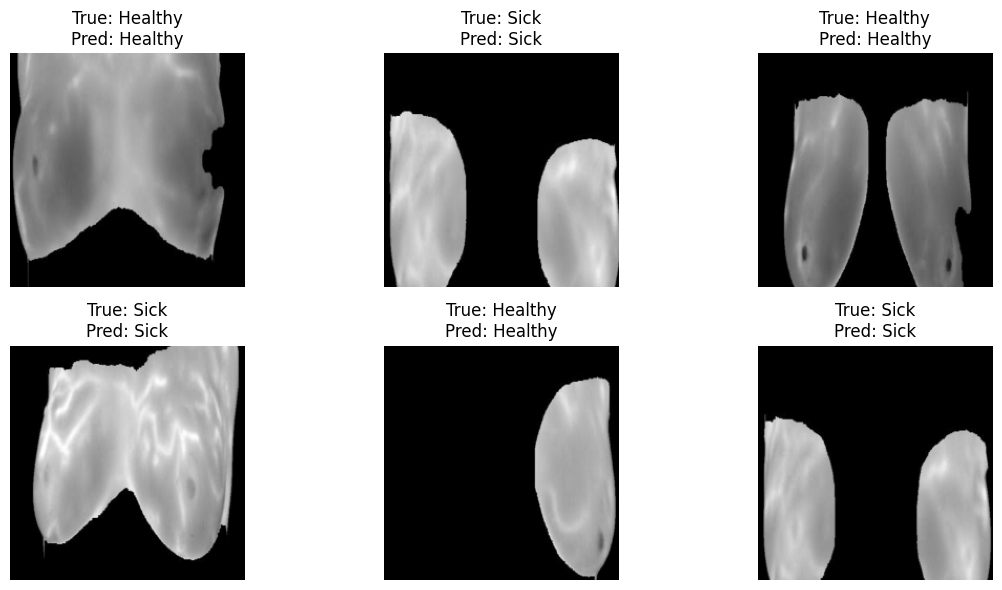

In [ ]:
# ----- PREDICTION VISUALIZATION -----
def show_grid_predictions(model, data_loader, class_names, device):
    model.eval()
    images, labels = next(iter(data_loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(6):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Unnormalize
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
show_grid_predictions(model, val_loader, class_names, device)

## EfficientNet-B0

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# ----- CONFIG -----
data_dir = "/content/drive/MyDrive/Breast Cancer Patients MRI/train"  # Change if needed
batch_size = 16
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- TRANSFORMS -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # EfficientNet expects 3 channels
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ----- DATASET -----
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ----- MODEL (EfficientNet-B0) -----
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)

# ----- TRAINING -----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    correct = total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}")

# ----- VALIDATION -----
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.numpy())

val_acc = accuracy_score(val_labels, val_preds)
cm = confusion_matrix(val_labels, val_preds)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Accuracy: {train_acc:.4f}" )



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 96.6MB/s]


Epoch 1/5 - Loss: 0.1914, Train Accuracy: 0.8679
Epoch 2/5 - Loss: 0.0168, Train Accuracy: 0.9598
Epoch 3/5 - Loss: 0.0359, Train Accuracy: 0.9786
Epoch 4/5 - Loss: 0.0590, Train Accuracy: 0.9643
Epoch 5/5 - Loss: 0.0313, Train Accuracy: 0.9732
Validation Accuracy: 0.9857
Train Accuracy: 0.9732


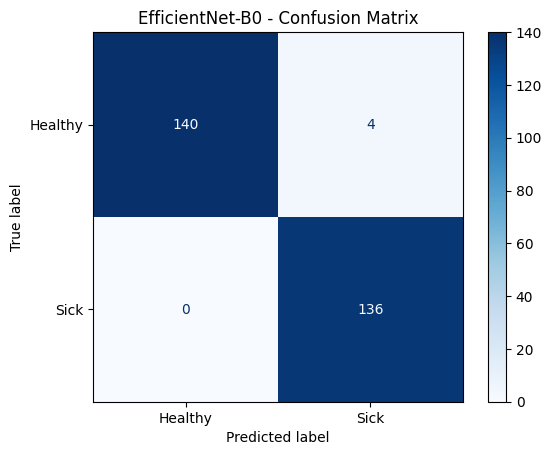

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("EfficientNet-B0 - Confusion Matrix")
plt.show()


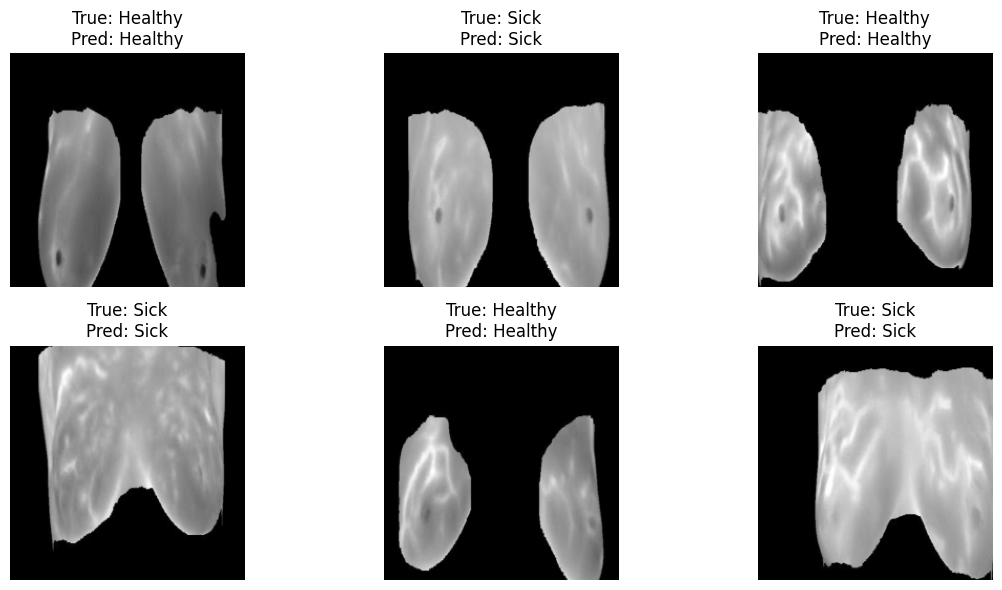

In [ ]:
# ----- PREDICTION VISUALIZATION -----
def show_grid_predictions(model, data_loader, class_names, device):
    model.eval()
    images, labels = next(iter(data_loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(6):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Unnormalize
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
show_grid_predictions(model, val_loader, class_names, device)

## MODEL COMPARISON


Training CustomCNN...
CustomCNN Epoch 1/5 - Loss: 0.3812 | Train Acc: 0.7554 | Val Acc: 0.9571
CustomCNN Epoch 2/5 - Loss: 0.2703 | Train Acc: 0.9348 | Val Acc: 0.9607
CustomCNN Epoch 3/5 - Loss: 0.1741 | Train Acc: 0.9812 | Val Acc: 0.9643
CustomCNN Epoch 4/5 - Loss: 0.0109 | Train Acc: 0.9902 | Val Acc: 0.9750
CustomCNN Epoch 5/5 - Loss: 0.1622 | Train Acc: 0.9911 | Val Acc: 0.9393


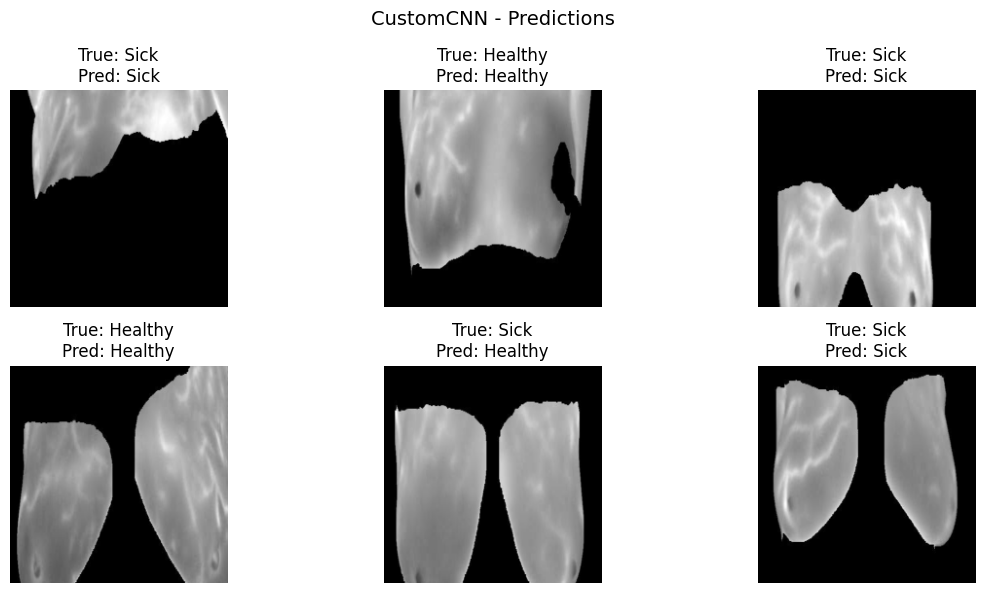


Training ResNet18...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18 Epoch 1/5 - Loss: 0.2565 | Train Acc: 0.8170 | Val Acc: 0.7857
ResNet18 Epoch 2/5 - Loss: 0.0515 | Train Acc: 0.9339 | Val Acc: 0.8821
ResNet18 Epoch 3/5 - Loss: 0.2510 | Train Acc: 0.9571 | Val Acc: 0.8500
ResNet18 Epoch 4/5 - Loss: 0.2583 | Train Acc: 0.9714 | Val Acc: 0.9821
ResNet18 Epoch 5/5 - Loss: 0.0034 | Train Acc: 0.9759 | Val Acc: 0.9750


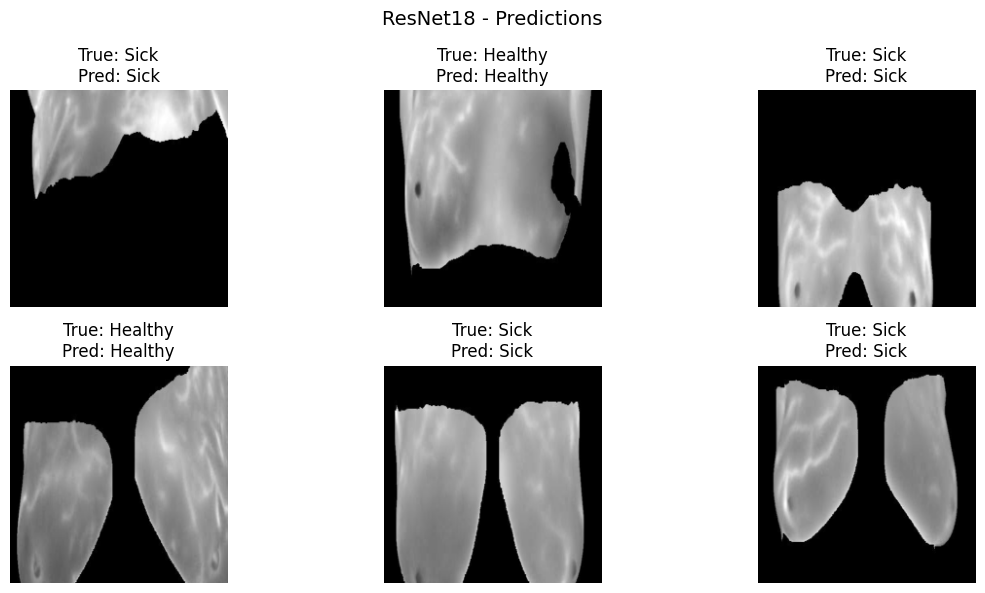


Training EfficientNetB0...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNetB0 Epoch 1/5 - Loss: 0.1852 | Train Acc: 0.8473 | Val Acc: 0.9429
EfficientNetB0 Epoch 2/5 - Loss: 0.1799 | Train Acc: 0.9464 | Val Acc: 0.9179
EfficientNetB0 Epoch 3/5 - Loss: 0.0699 | Train Acc: 0.9643 | Val Acc: 0.9893
EfficientNetB0 Epoch 4/5 - Loss: 0.0009 | Train Acc: 0.9795 | Val Acc: 0.9786
EfficientNetB0 Epoch 5/5 - Loss: 0.0191 | Train Acc: 0.9938 | Val Acc: 0.9929


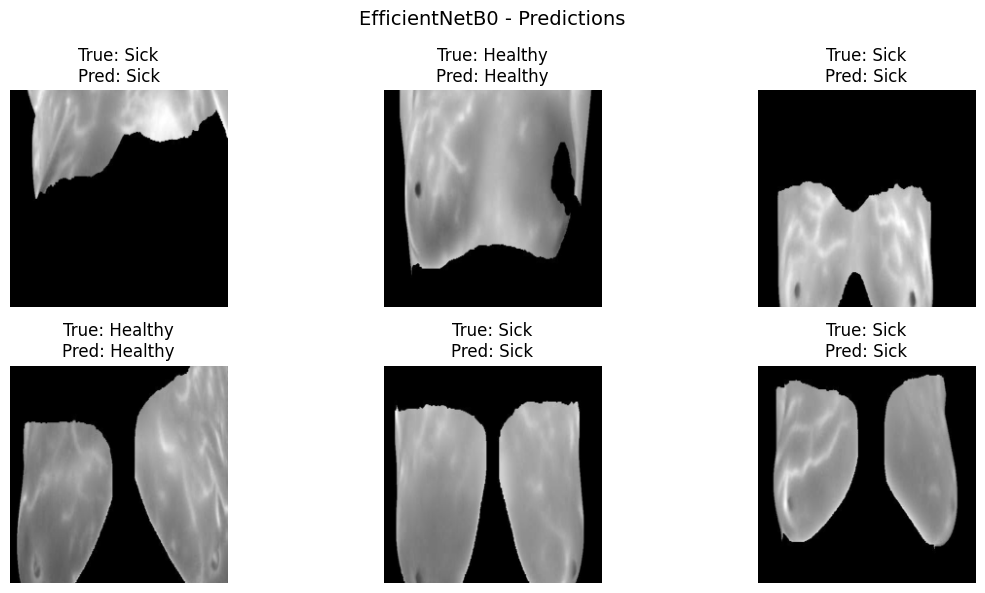

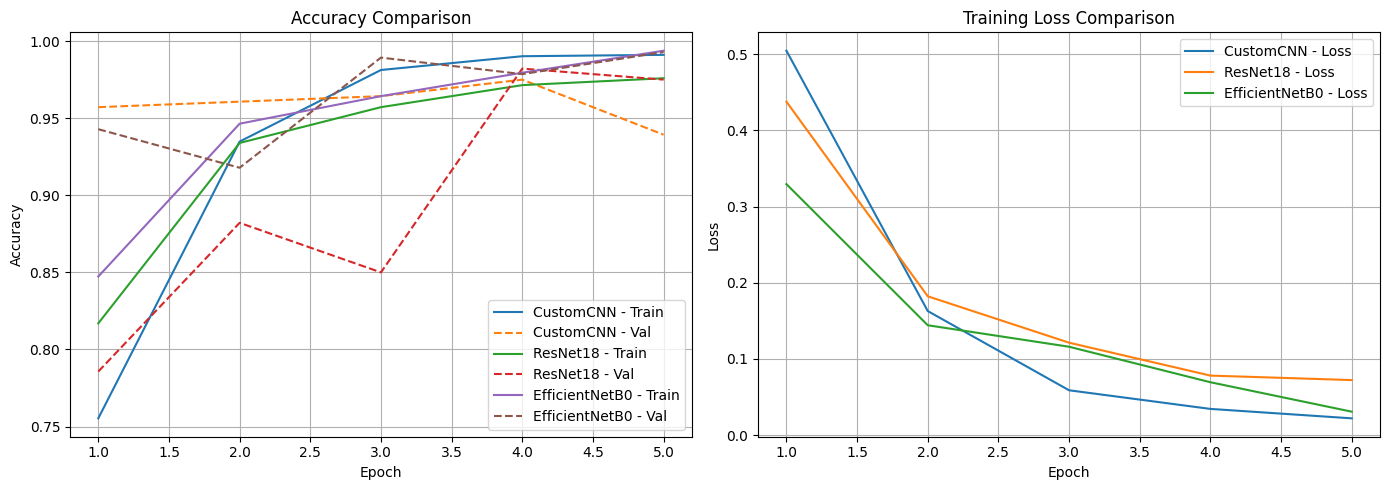

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# ----- CONFIG -----
data_dir = "/content/drive/MyDrive/Breast Cancer Patients MRI/train"  # Adjust path
batch_size = 16
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- TRANSFORMS -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ----- DATASET -----
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ----- MODELS -----
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.net(x)

def get_resnet18():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

def get_efficientnet():
    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    return model

# ----- TRAINING FUNCTION -----
def train_model(model, name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accs, val_accs, losses = [], [], []

    for epoch in range(num_epochs):
        model.train()
        correct = total = 0
        running_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

        train_acc = correct / total
        train_accs.append(train_acc)
        losses.append(running_loss / len(train_loader))

        # Validation accuracy
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_accs.append(val_acc)
        print(f"{name} Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return model, train_accs, val_accs, losses

# ----- PREDICTION VISUALIZATION (Optional) -----
def show_predictions(model, title):
    model.eval()
    images, labels = next(iter(val_loader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(6):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis("off")
    plt.suptitle(f"{title} - Predictions", fontsize=14)
    plt.tight_layout()
    plt.show()

# ----- RUN COMPARISON -----
results = {}

for name, model_fn in [("CustomCNN", CustomCNN), ("ResNet18", get_resnet18), ("EfficientNetB0", get_efficientnet)]:
    print(f"\nTraining {name}...")
    model, train_accs, val_accs, losses = train_model(model_fn(), name)
    results[name] = {'train_acc': train_accs, 'val_acc': val_accs, 'loss': losses}
    show_predictions(model, name)

# ----- PLOT COMPARISON -----
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(epochs, results[name]['train_acc'], label=f'{name} - Train')
    plt.plot(epochs, results[name]['val_acc'], linestyle='--', label=f'{name} - Val')
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
for name in results:
    plt.plot(epochs, results[name]['loss'], label=f'{name} - Loss')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## BAR PLOT: Final Accuracy Comparison

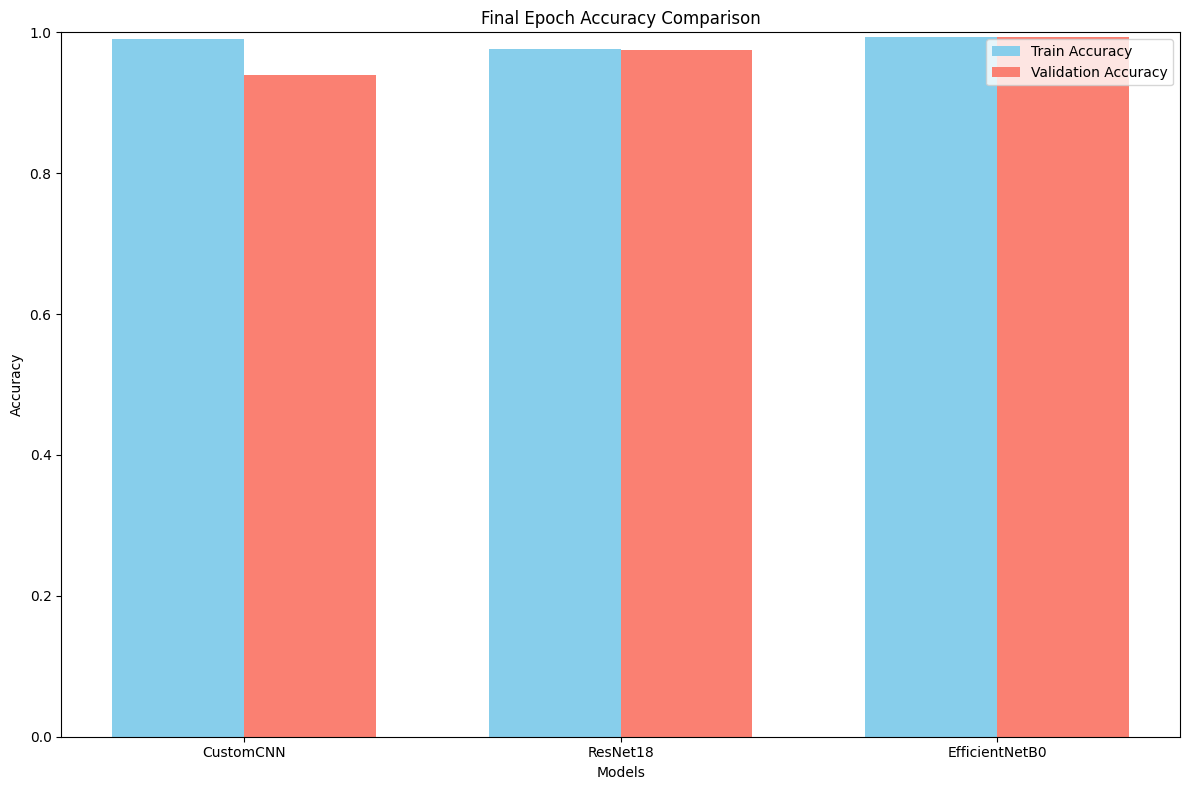

CustomCNN - Final Train Acc: 0.9911, Final Val Acc: 0.9393
ResNet18 - Final Train Acc: 0.9759, Final Val Acc: 0.9750
EfficientNetB0 - Final Train Acc: 0.9938, Final Val Acc: 0.9929


In [ ]:

model_names = list(results.keys())
train_final_acc = [results[m]['train_acc'][-1] for m in model_names]
val_final_acc = [results[m]['val_acc'][-1] for m in model_names]

x = np.arange(len(model_names))
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.bar(x, train_final_acc, width=bar_width, label='Train Accuracy', color='skyblue')
plt.bar(x + bar_width, val_final_acc, width=bar_width, label='Validation Accuracy', color='salmon')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Final Epoch Accuracy Comparison")
plt.xticks(x + bar_width / 2, model_names)
plt.ylim(0, 1)
plt.legend()
# plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print final accuracy results
for i, name in enumerate(model_names):
    print(f"{name} - Final Train Acc: {train_final_acc[i]:.4f}, Final Val Acc: {val_final_acc[i]:.4f}")


In [ ]:
!pip install gradio
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.2 MB/s eta 0:00:00


In [ ]:
def predict_efficientnet(img):
    img = img.resize((224, 224))
    img = np.array(img) / 255.00
    img = np.expand_dims(img, axis=0)
    prediction = efficientnet_model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return class_names[predicted_class]


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add custom layers...


In [ ]:
def predict_resnet(img):
    img = img.resize((224, 224))
    img = np.array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    prediction = resnet_model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return class_names[predicted_class]


In [ ]:
import gradio as gr

def predict_image(img, model_choice):
    if model_choice == "EfficientNetB0":
        return predict_efficientnet(img)
    elif model_choice == "ResNet50":
        return predict_resnet(img)
    elif model_choice == "Custom CNN":
        return predict_custom_cnn(img)
    else:
        return "Invalid model selected"

interface = gr.Interface(
    fn=predict_image,
    inputs=[gr.Image(type="pil"), gr.Dropdown(["Custom CNN", "EfficientNetB0", "ResNet50"])],
    outputs="text"
)
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dca7d025f0baf341d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
